# Setup

In [1]:
import os
import random
from dataclasses import dataclass
from tqdm import tqdm

import torch
from torch.distributions.normal import Normal
from torch.distributions.uniform import Uniform
import numpy as np
import torchvision.transforms as T
from torch.utils.data import Dataset, DataLoader
from datasets import load_dataset
from transformers import get_cosine_schedule_with_warmup
from diffusers import (
    StableDiffusionPipeline, 
    StableDiffusionImg2ImgPipeline,
    StableDiffusionInpaintPipeline, 
    StableDiffusionDepth2ImgPipeline
    )    
import wandb
import matplotlib.pyplot as plt

from data.datasets.web_dataset import get_dataset
from instructflow.utils import show_images, seed_everything   
from instructflow.generation import generate_euler, generate_euler_cfg
from instructflow.inversion import generate_inverse

In [2]:
import yaml
from omegaconf import OmegaConf
import tempfile


with open("configs/sd2_baseline.yaml", "r") as fp:
    config = OmegaConf.load(fp.name)

In [3]:
seed_everything(config.system.random_state)
torch.set_float32_matmul_precision(config.system.pf32_precision)

In [4]:
scale = T.Lambda(
    lambda x: x * 2 - 1
)

inverse_scale = T.Lambda(
    lambda x: (x + 1) / 2
)


transform = T.Compose([
    T.ToTensor(),
    scale
])

inverse_transform = T.Compose([
    inverse_scale,
    T.Lambda(lambda x: x.permute(1, 2, 0))
])

# Generating Images from Text

In [5]:
# Load the pipeline
pipe = StableDiffusionPipeline.from_pretrained(config.model.model_id).to(config.trainer.device)

/home/jovyan/.local/lib/python3.11/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/35 [00:00<?, ?it/s]

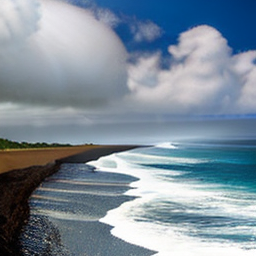

In [6]:
# Set up a generator for reproducibility
generator = torch.Generator(device=config.trainer.device).manual_seed(config.system.random_state)

# Run the pipeline, showing some of the available arguments
pipe_output = pipe(
    prompt="Surfer on maui", # What to generate
    negative_prompt="Oversaturated, blurry, low quality", # What NOT to generate
    height=256, 
    width=256,     # Specify the image size
    guidance_scale=4,          # How strongly to follow the prompt
    num_inference_steps=35,    # How many steps to take
    generator=generator        # Fixed random seed
)

# View the resulting image
pipe_output.images[0]

In [7]:
import math

approx_num_samples, dataset = get_dataset(config.data)
approx_num_batches = math.ceil(approx_num_samples / config.data.dataloader.batch_size)

dataloader = DataLoader(
        dataset,
        batch_size=config.data.dataloader.batch_size,
        num_workers=config.data.dataloader.num_workers,
        pin_memory=True,
    )

!!! DATASET SIZE !!! 278964


# Model

In [8]:
last_checkpoint = os.listdir("checkpoints/sd_2_1_fm_generation_v1")[-1]
last_checkpoint

'595000.pt'

In [9]:
unet = pipe.unet.eval()
vae = pipe.vae.eval()
text_encoder = pipe.text_encoder.eval()

unet.load_state_dict(torch.load(f"checkpoints/sd_2_1_fm_generation_v1/{last_checkpoint}"))

<All keys matched successfully>

In [10]:
device = config.trainer.device
device

'cuda'

# Inversion

In [11]:
from PIL import Image

x_1 = transform(Image.open("dog.jpeg").resize((256, 256))).unsqueeze(dim=0)
x_1.shape

torch.Size([1, 3, 256, 256])

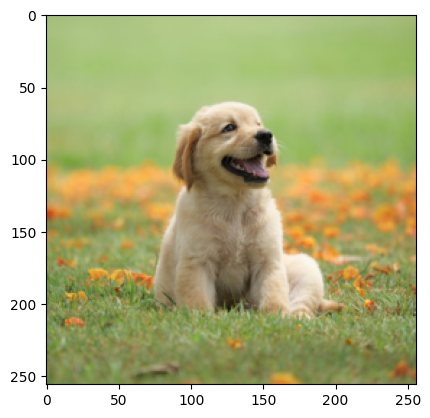

In [12]:
plt.imshow(inverse_scale(x_1[0].permute(1, 2, 0)))

In [13]:
null_prompts = [''] * 1
null_encoder_out = pipe.tokenizer(null_prompts, padding="max_length", max_length=16, return_tensors="pt")

with torch.no_grad():
    null_encoder_hidden_states = text_encoder(null_encoder_out["input_ids"].to(device), null_encoder_out["attention_mask"].to(device))['last_hidden_state']

null_encoder_hidden_states.shape

torch.Size([1, 16, 1024])

In [14]:
prompts = [
    "Puppy sitting on the grass",  
]

encoder_out = pipe.tokenizer(prompts, padding="max_length", max_length=16, return_tensors="pt")

with torch.no_grad():
    encoder_hidden_states = text_encoder(encoder_out["input_ids"].to(device), encoder_out["attention_mask"].to(device))['last_hidden_state']

encoder_hidden_states.shape

torch.Size([1, 16, 1024])

In [15]:
new_prompts = [
    "Kitten sitting on the grass",  
]

new_encoder_out = pipe.tokenizer(new_prompts, padding="max_length", max_length=16, return_tensors="pt")

with torch.no_grad():
    new_encoder_hidden_states = text_encoder(new_encoder_out["input_ids"].to(device), new_encoder_out["attention_mask"].to(device))['last_hidden_state']

new_encoder_hidden_states.shape

torch.Size([1, 16, 1024])

In [16]:
with torch.no_grad():
    x_1_latents = 0.18215 * vae.encode(x_1.cuda()).latent_dist.mean

x_1_latents.shape

torch.Size([1, 4, 32, 32])

## Inverse

tensor(-3.7420, device='cuda:0') tensor(0.0209, device='cuda:0') tensor(3.8589, device='cuda:0')


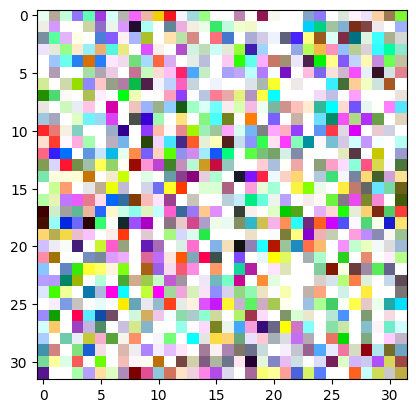

In [17]:
x_gen_inverse = generate_inverse(
    unet=unet, 
    vae=vae, 
    x_0=x_1_latents, 
    encoder_hidden_states=encoder_hidden_states, 
    device=device
)

print(x_gen_inverse.min(), x_gen_inverse.mean(), x_gen_inverse.max())

plt.imshow(show_images(x_gen_inverse))

## Reconstruct

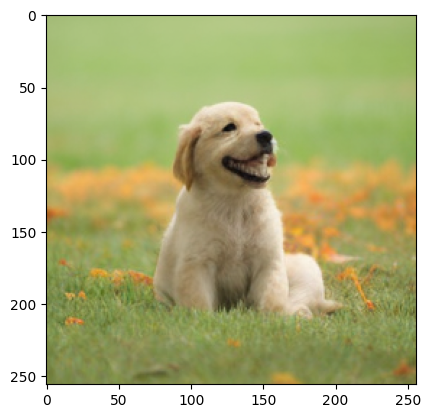

In [18]:
x_gen = generate_euler(
    unet=unet, 
    vae=vae, 
    x_0=x_gen_inverse, 
    encoder_hidden_states=encoder_hidden_states,
    device=device
)

plt.imshow(inverse_transform(x_gen[0].cpu()))

## Instructivey change the image

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


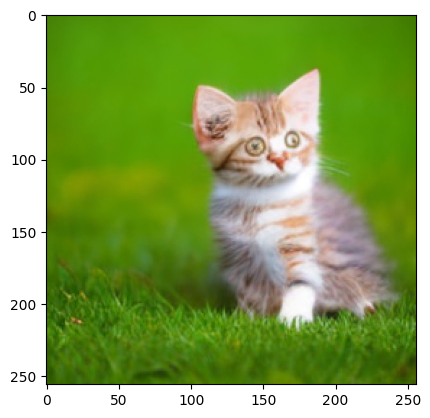

In [19]:
x_gen = generate_euler_cfg(
    unet=unet, 
    vae=vae, 
    x_0=x_gen_inverse, 
    encoder_hidden_states=new_encoder_hidden_states,
    null_encoder_hidden_states=null_encoder_hidden_states,
    guidance_scale=5.0,
    device=device
)

plt.imshow(inverse_transform(x_gen[0].cpu()))